In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
dataset_PT = TSD(categories=['sc'], file_path="../datasets/PT_dataset_imputed.csv")

Dataset loaded from ../datasets/PT_dataset_imputed.xlsx


/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[<Axes: title={'center': 'overturn'}>,
        <Axes: title={'center': 'predecessor_assassination'}>,
        <Axes: title={'center': 'intra_elite'}>],
       [<Axes: title={'center': 'military_revolt'}>,
        <Axes: title={'center': 'popular_uprising'}>,
        <Axes: title={'center': 'separatist_rebellion'}>],
       [<Axes: title={'center': 'external_invasion'}>,
        <Axes: title={'center': 'external_interference'}>,
        <Axes: title={'center': 'labels'}>]], dtype=object)

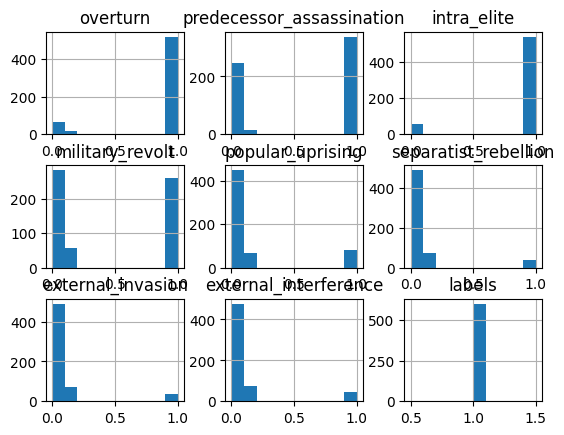

In [21]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]

knn_dat = dataset_PT.scv_imputed[crisis_vars].dropna()

# perform KNN nearest neighbors clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(knn_dat)
knn_dat['labels'] = kmeans.labels_

knn_dat.loc[knn_dat['labels'] == 1].hist()

In [7]:
scale_cols = ['Pop','Terr','Cap','Hierarchy']
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money','MSP']
input_cols = scale_cols + non_scale_cols
crisis_cols = ['overturn']

from sklearn.model_selection import train_test_split

Xy = dataset_PT.scv_imputed[input_cols + crisis_cols].dropna()

df_x = Xy[input_cols]
df_y = Xy[crisis_cols]
df_y = df_y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {input_cols[indices[f]]} ({importances[indices[f]]})")

[[187  40]
 [ 67  58]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       227
           1       0.59      0.46      0.52       125

    accuracy                           0.70       352
   macro avg       0.66      0.64      0.65       352
weighted avg       0.68      0.70      0.69       352

Feature ranking:
1. feature Terr (0.2274174127435604)
2. feature Pop (0.18559335091646728)
3. feature Cap (0.1580197521369339)
4. feature Hierarchy (0.1398217688765895)
5. feature Information (0.07284169211375888)
6. feature Government (0.07184035377874279)
7. feature Infrastructure (0.06997959195644707)
8. feature MSP (0.038304610464303696)
9. feature Money (0.03618146701319658)
